## Milestone 2: Hand in 


In this notebook we start the project regarding:
### **The representation of women in media**

This notebook includes:
1. The clean data loading
2. The loading of the additional datasets
3. The basic data analysis including plots, their observations as well as statistical tests and their interpretation



The **research questions** we wish to answer are the following:

- How does the **distribution of quotes based on gender vary across countries, categories, media and time**?

- Is there a difference in how females/males at a **certain age** are quoted?

- Do males have **longer** quotes than females?

- Are males more likely to be quoted in **highly respected media/media with most quotations**? 

- Are there any blind spots in media where females are **neglected**?

- Are countries known to promote gender equality more likely to reflect this in media compared to the rest of the world ?

# Import packages

In [1]:
# Libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle

In [2]:
from M2_media_wikidata import *
from M2_cleaning import *
from M2_plots import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lavinia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/lavinia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#Settings for the plots 
sns.set_style("ticks")
colors= sns.color_palette('colorblind')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=18)
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 6

sns.set_style("darkgrid", {'axes.grid' : False, 'ytick.left': True, 'xtick.bottom': True})

# 0. Cleaning process # 
#### See notebook `M2_pre_processing.ipynb`

# 1. Load cleaned data

In [4]:
DATA_PATH = './data/'

DATA_PATH2015 = DATA_PATH + 'data_2015/'
DATA_PATH2016 = DATA_PATH + 'data_2016/'
DATA_PATH2017 = DATA_PATH + 'data_2017/'
DATA_PATH2018 = DATA_PATH + 'data_2018/'
DATA_PATH2019 = DATA_PATH + 'data_2019/'
DATA_PATH2020 = DATA_PATH + 'data_2020/'

FILE2015 = DATA_PATH2015 + 'df_2015_no_media_quotes.pkl'
FILE2016 = DATA_PATH2016 + 'df_2016_no_media_quotes.pkl'
FILE2017 = DATA_PATH2017 + 'df_2017_no_media_quotes.pkl'
FILE2018_1 = DATA_PATH2018 + 'df_2018_no_media_quotes_part1.pkl'
FILE2018_2 = DATA_PATH2018 + 'df_2018_no_media_quotes_part2.pkl'
FILE2019 = DATA_PATH2019 + 'df_2019_no_media_quotes.pkl'
FILE2020 = DATA_PATH2020 + 'df_2020_no_media_quotes.pkl'

FILES = [FILE2015, FILE2016, FILE2017, FILE2018_1, FILE2018_2, FILE2019, FILE2020]

MEDIA_COUNTRY2015 = DATA_PATH2015 + 'df_2015_media_country.pkl'
MEDIA_COUNTRY2016 = DATA_PATH2016 + 'df_2016_media_country.pkl'
MEDIA_COUNTRY2017 = DATA_PATH2017 + 'df_2017_media_country.pkl'
MEDIA_COUNTRY2018 = DATA_PATH2018 + 'df_2018_media_country.pkl'
MEDIA_COUNTRY2019 = DATA_PATH2019 + 'df_2019_media_country.pkl'
MEDIA_COUNTRY2020 = DATA_PATH2020 + 'df_2020_media_country.pkl'

MEDIA_COUNTRIES = [MEDIA_COUNTRY2015, MEDIA_COUNTRY2016, MEDIA_COUNTRY2017, MEDIA_COUNTRY2018, MEDIA_COUNTRY2019, MEDIA_COUNTRY2020]

*Note*: Files had to be opened separately for smooth running and decreases the chances of having a dying kernel

In [5]:
with open(FILE2015, 'rb') as input_file:
    df_2015 = pickle.load(input_file)

In [6]:
with open(FILE2016, 'rb') as input_file:
    df_2016 = pickle.load(input_file)

In [7]:
with open(FILE2017, 'rb') as input_file:
    df_2017 = pickle.load(input_file)

In [8]:
with open(FILE2018_1, 'rb') as input_file:
    df_2018_1 = pickle.load(input_file)

In [9]:
with open(FILE2018_2, 'rb') as input_file:
    df_2018_2 = pickle.load(input_file)

In [10]:
with open(FILE2019, 'rb') as input_file:
    df_2019 = pickle.load(input_file)

In [11]:
with open(FILE2020, 'rb') as input_file:
    df_2020 = pickle.load(input_file)

In [12]:
"""
    Note: 2018 was split in two for the pickle and recombined for the analysis
"""
df_2018 = df_2018_1.append(df_2018_2).reset_index(drop=True)

In [13]:
df_list = []
df_list.append(df_2015)
df_list.append(df_2016)
df_list.append(df_2017)
df_list.append(df_2018)
df_list.append(df_2019)
df_list.append(df_2020)

# 2. Addition of datasets
The following function allows us to add the country of origin of the newspappers in which the quotes may be found, this will be used to analyse the geographic tendencies of quoting different genders accross the world

- Countries to continent (the data is merged in cells further below): `countries_to_continent.csv`
- Countries and their respective wikidata QID: `quids_to_country.pkl`
- Country of the selected medias: `df_{year}_media_country.pkl`

In [14]:
# Load continents
countries_to_continent = pd.read_csv(DATA_PATH+'Countries_to_continent.csv', sep=';')


In [15]:
# Load QIDS to countries
with open(DATA_PATH + 'qid_country.pkl', 'rb') as input_file:
    qids_to_country = pickle.load(input_file)

In order to output the countries of the selected media we query Wikidata using its API to match the URL to an official website of the media registered on Wikidata. Then we extract its QID in order to fetch additional information on the media such as its location

In [16]:
# This boolean allows for running the extraction of the media's country 
RUN_MEDIA_COUNTRY = False

if RUN_MEDIA_COUNTRY:
    for FILE in FILES:
        # Open data frame
        with open(FILE, 'rb') as d_file:
            df = pickle.load(d_file)

        # Keep the sitenames of interest to extract the URLS of these sites 
        df_top_url_site = df.explode(["sitenames", "urls"]).drop_duplicates(subset = ["sitenames"],keep = "first")[["urls", "sitenames"]]

        top_sites_URL = df_top_url_site["urls"]
        top_sitename = df_top_url_site["sitenames"]

        # Extract from wikidata the country of the media 
        country_list_top_media = extract_info_wiki(top_sites_URL)

        # Put into dataframe
        df_top_media  =pd.DataFrame(media_country_dic)

        # For each row of the dataframe we associate the different sitenames that cited the quote to their respective country
        country_media_column = []
        for i in range (len(df)):
            country_media_column.append(df_top_media[df.iloc[i]["sitenames"]].iloc[0].values)

        # Pickle save the new country column for each media 
        with open(MEDIA_COUNTRIES[i], 'wb') as output:
            pickle.dump(country_media_column, output)


**Important note**:
We are aware than even though the sitenames are the same, 
the URL may be from different sub-websites and therefore may have different countries. 
The current way will be upgraded in the following week for more accurate results. 
This will be done by running the `extract_info_wiki` function  on all the rows


In [17]:
# Add the media country to each yearly dataframe
for i in range(len(df_list)):
    with open(MEDIA_COUNTRIES[i], 'rb') as input_file:
        df_list[i]["media_country_qid"] = pickle.load(input_file)

# 3. Basic data analysis

## 3.1 Number of quotes per gender

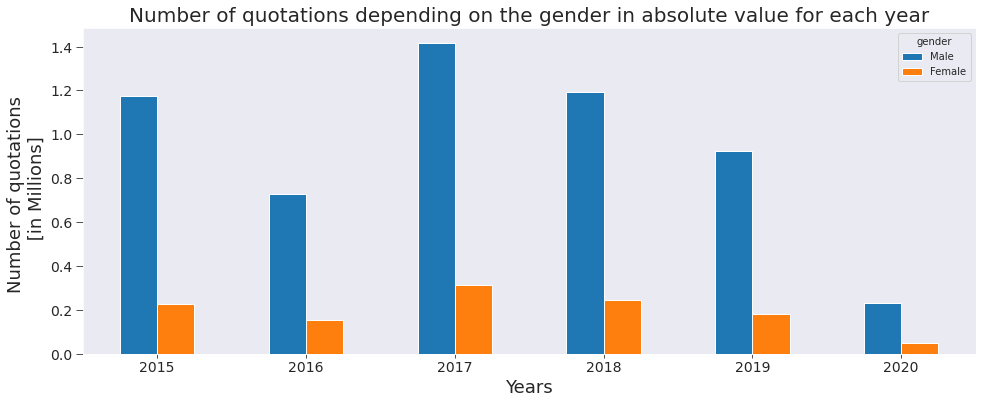

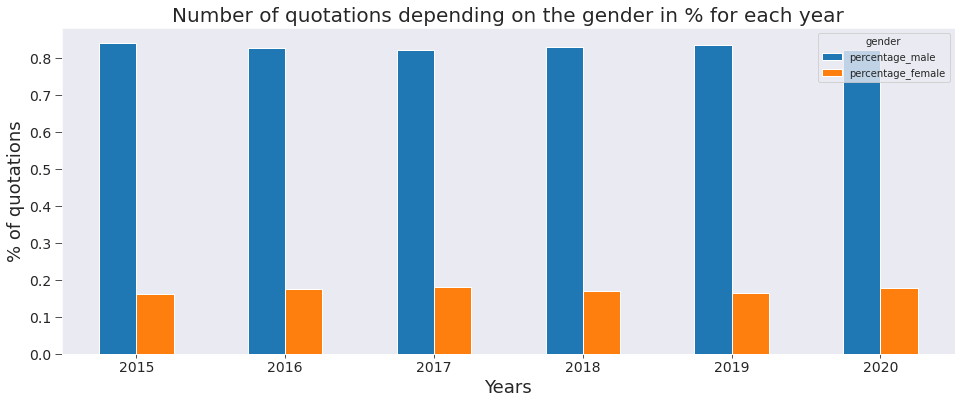

In [18]:
gender_all_years_extended = gender_all_years_extension(df_list)
plot_gender_all_years(gender_all_years_extended)

**Observation** : 
The plot showing the proportion of quotes depending on the gender shows a clear gap between the number of males and females. Indeed, women account for only around 20% of quotes, while males amount for the rest. The quotes are those belonging to the 10 most present sources in the data each year, which could account for a bias. Nonetheless, due to the high number of quotes these produce, likely in all type of subjects, we can assume that these medias are not targetted towards a certain gender and should not favor a gender over the other. (The media sources are explicitely shown in steps below, confirming this assumption). With this in mind, it appears that there is a real gender gap in media that stays constant throughout the years.

##### Statistical tests over the years

In [19]:
results_gender = perform_linear_regression('percentage_female', 'year', gender_all_years_extended)

                            OLS Regression Results                            
Dep. Variable:      percentage_female   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                 -0.096
Method:                 Least Squares   F-statistic:                    0.5601
Date:                Fri, 12 Nov 2021   Prob (F-statistic):              0.496
Time:                        21:20:08   Log-Likelihood:                 21.560
No. Observations:                   6   AIC:                            -39.12
Df Residuals:                       4   BIC:                            -39.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7703      3.931     -0.705      0.5

/home/lavinia/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


**Observation** : 
The linear regression aims at analysing the effect of the year (predictor) on the outcome (% Female).

- Using the equation `Percentage Female ~ year`, the model yields us the results shown above
- The `m` coefficient (= 0.001748 %/year) is of interest, because it represents the slope of the linear regression. The percentage of females being quoted seems to evolve with the years.
- However, with its p_value of 0.38, one should not refuse the null-hypothesis of the model: "The considered predictor has no impact on the outcome".
- This model tends hence to support the fact that the relative representation of females in the most popular media of each year is independant (and hence constant) on the years.


## Age

In [20]:
#To be run once only !
bins = np.arange(0,110,step=10)
for df in df_list:
    df = compute_age_and_agerange(df, bins)

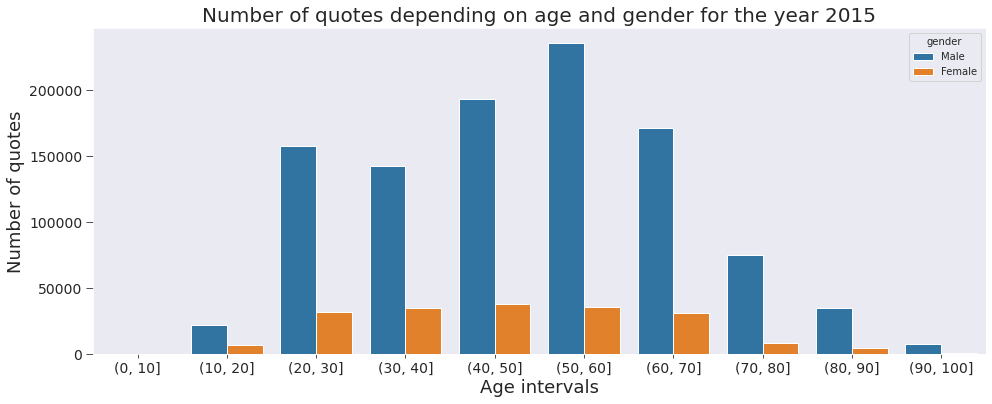

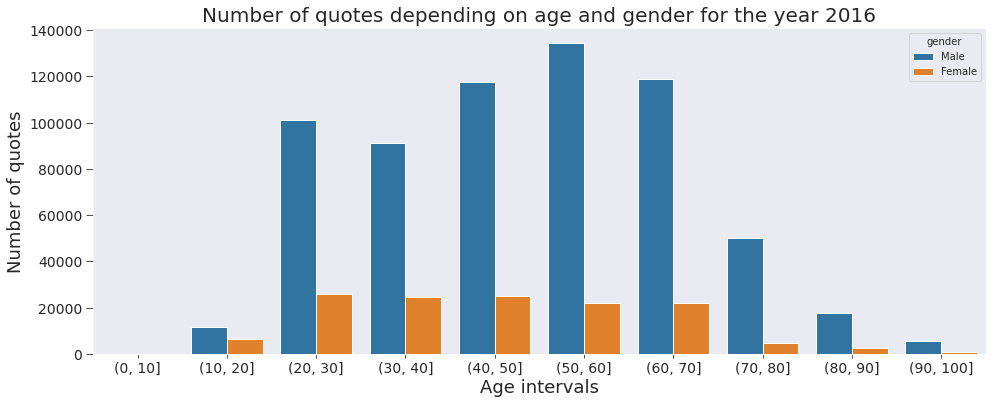

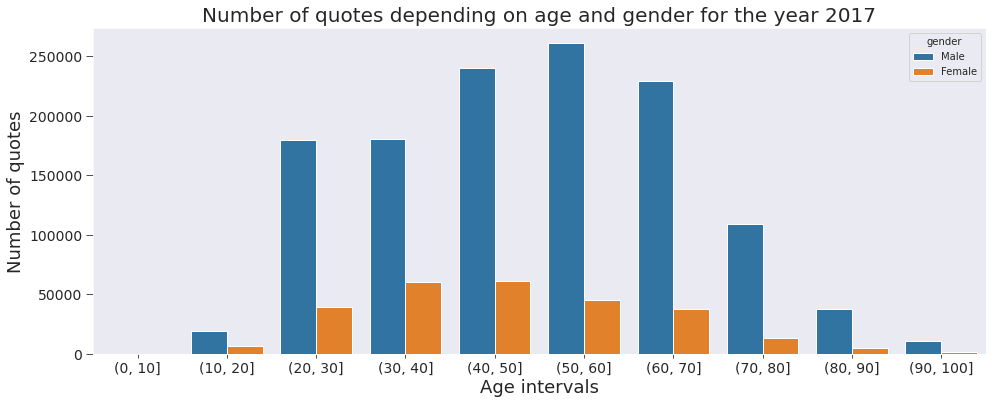

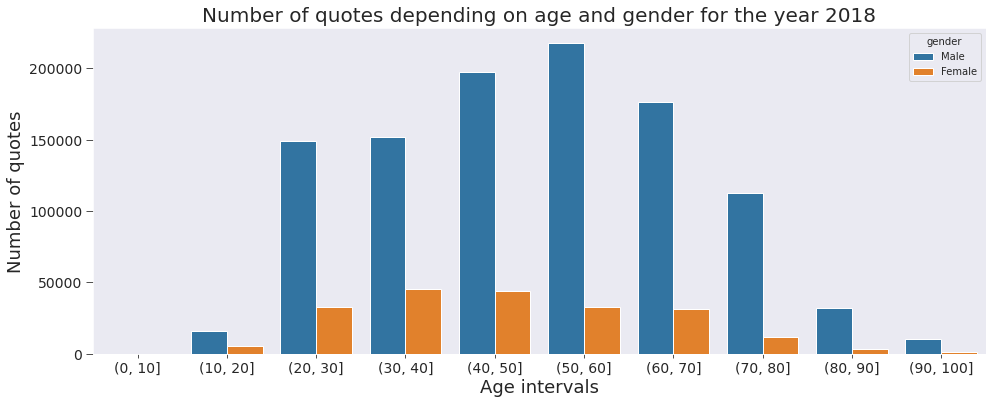

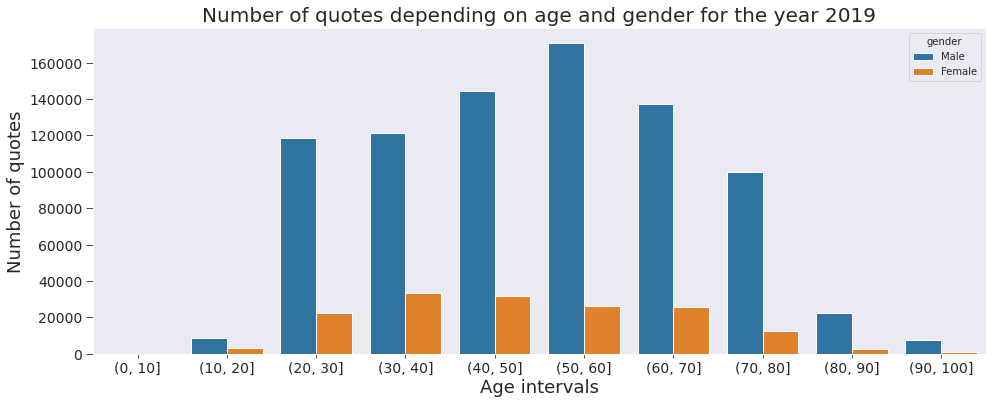

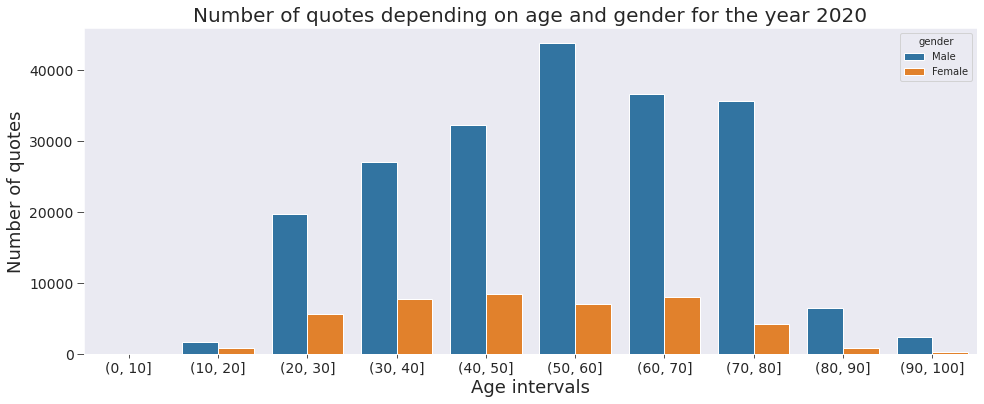

In [21]:
for df in df_list:
    plot_quotes_age(df, age_threshold = 100)

**Observation** :
- For both gender, the distribution seems to be normal (a test is to be run to verify this observation)
- Males of age from 50 to 60 seem to be more quoted for each year 
- Females of age from 30 to 40 seem to be more quoted for each year 
- This may reinforce the perspective of an older wise male whereas a female may loose her value as she ages

**Statistical test for the age** : 

In [22]:
# Perfom T-test
for df in df_list:
    p_value_age = perform_t_test(df[df['gender']=='Male']['age'],df[df['gender']=='Female']['age'])

In [24]:
# Test to see if the distribution is normal

stat_test_m, pvalue_norm_male = stats.normaltest(df[df['gender']=='Male']['age'], axis=0, nan_policy='propagate')
stat_test_f, pvalue_norm_female = stats.normaltest(df[df['gender']=='Female']['age'], axis=0, nan_policy='propagate')



## Countries

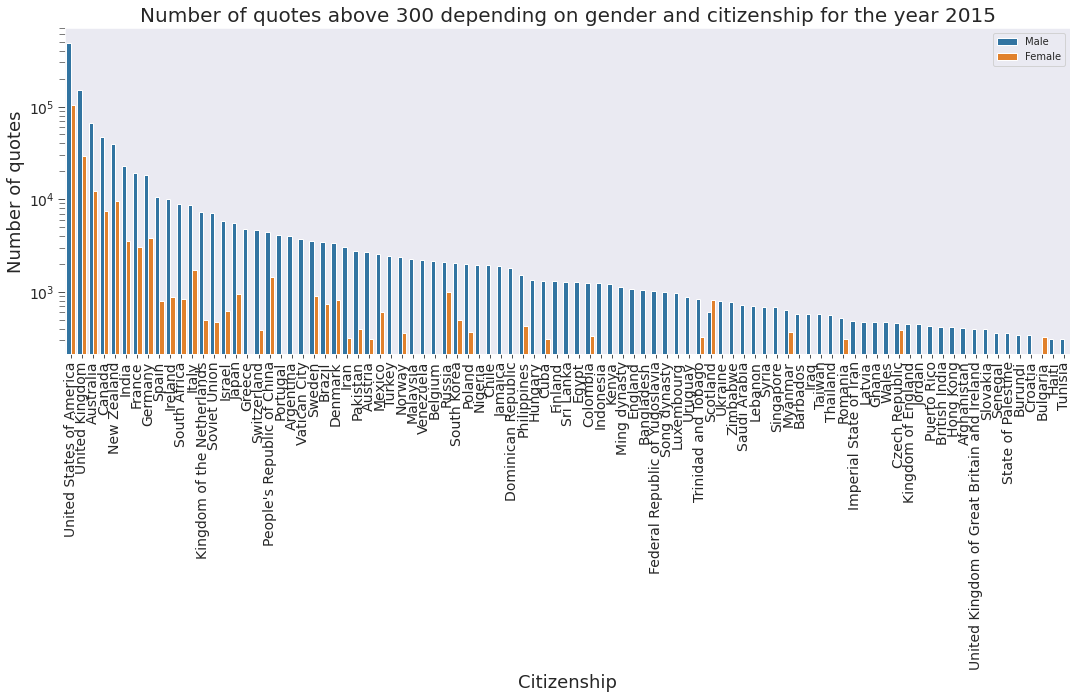

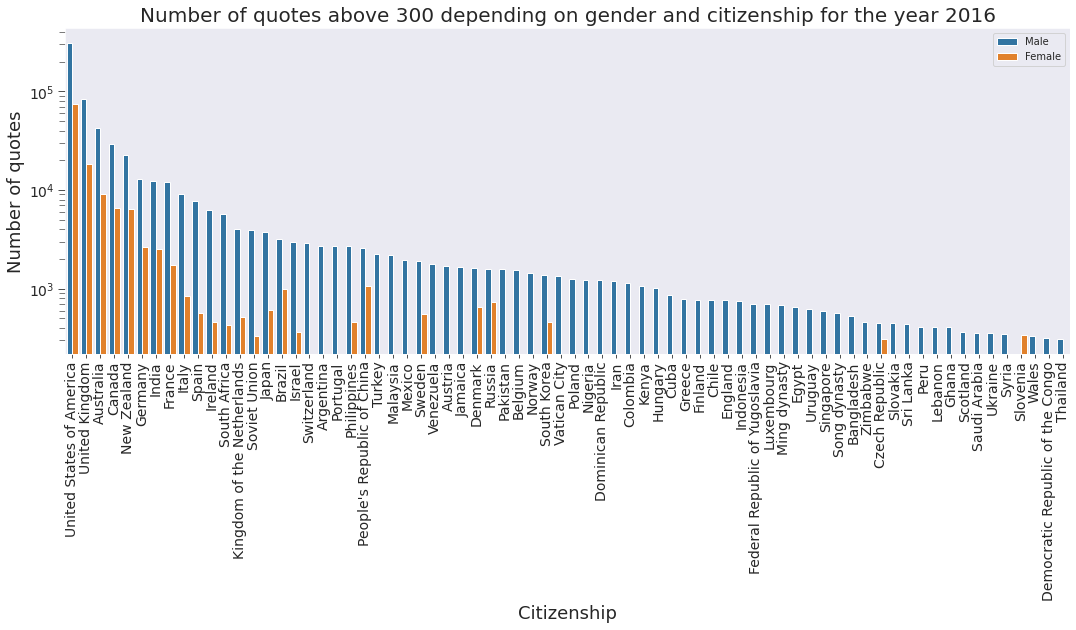

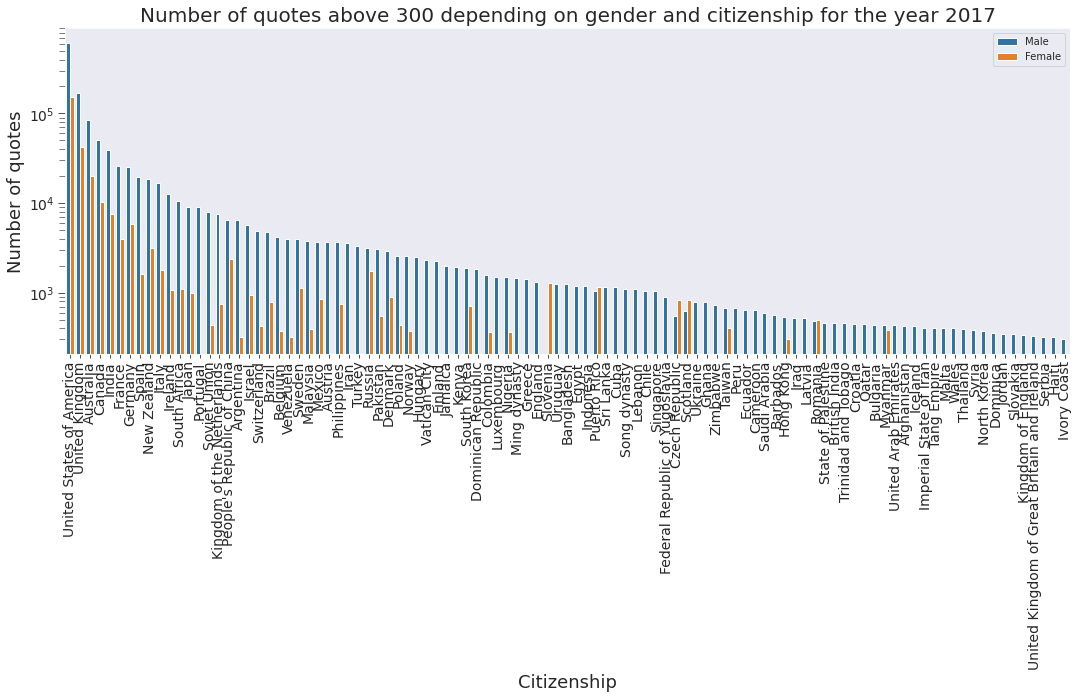

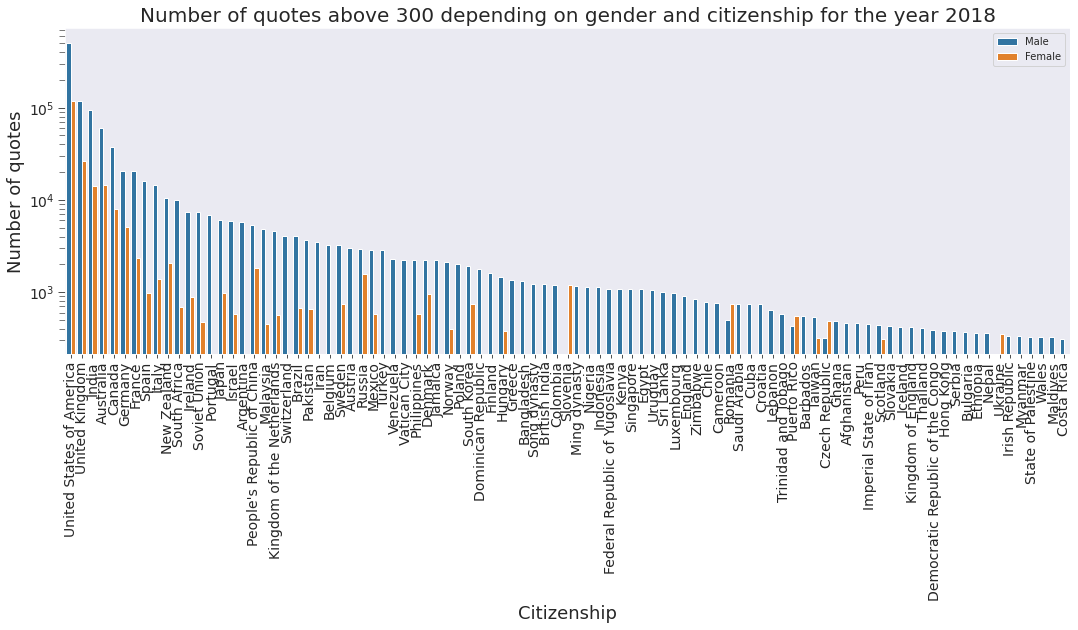

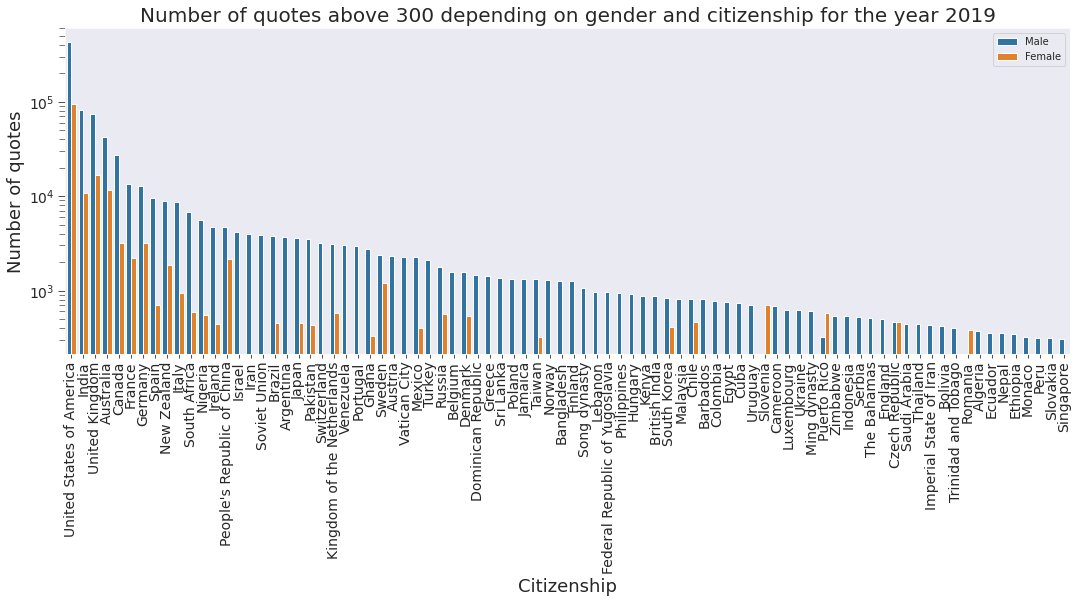

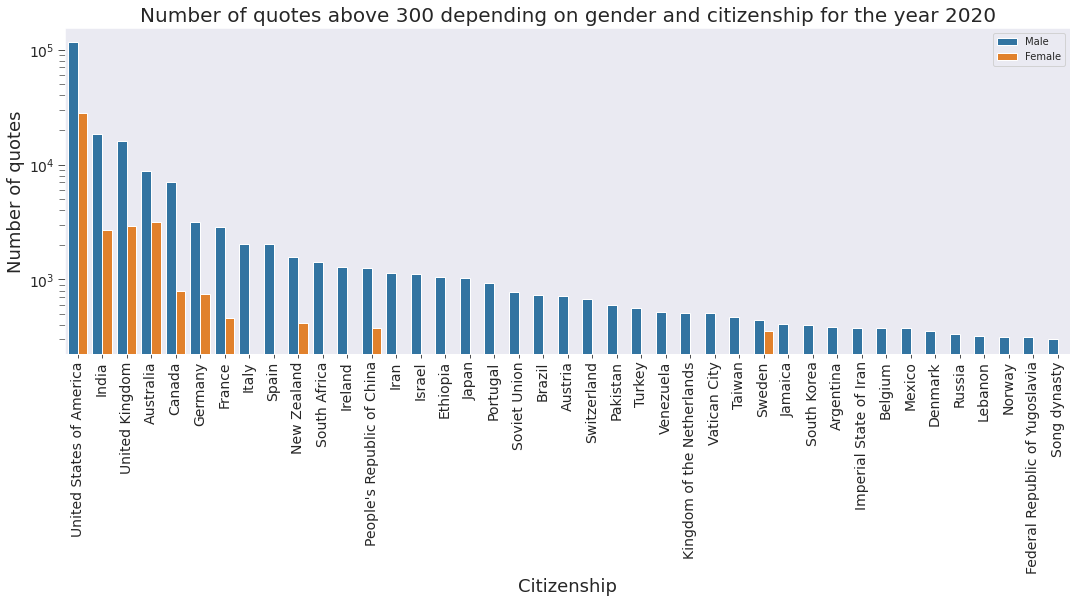

In [25]:
for df in df_list:
    plot_quotes_country(df, threshold_nber = 300)

**Observation** :

- This plot shows the count of male and female quotes for the countries present in the dataset. The country corresponds to the citizenship of the speaker
- For readbility, the data is plotted using a log-y scale.
- The vast majority of countries quote more males than females.
- The number of countries changes every year, but USA is the source of most quotes each year.
- We also see that most quotes originate from the USA.
- Some exceptions that reoccur almost every year and have close to equal/more female quotes are: Scotland, Bulgaria, Czech Republic, Slovenia.
- To understand why this might be the case, we need to look at the quotes and types of articles corresponding to these countries. It is important to understand whether the articles were targeted towards a certain public or not before making conclusions. This will be done in a future step.
- We will also look at change over the years in more detail.



## Continents

In [ ]:
for df in df_list:
    df["Continent"] = add_continent(df, countries_to_continent)

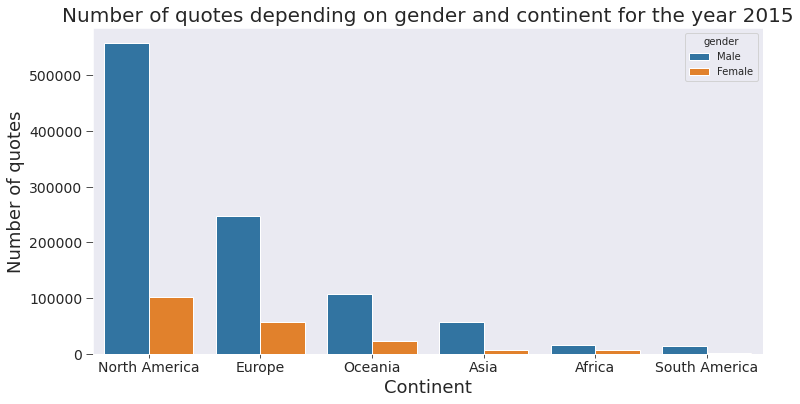

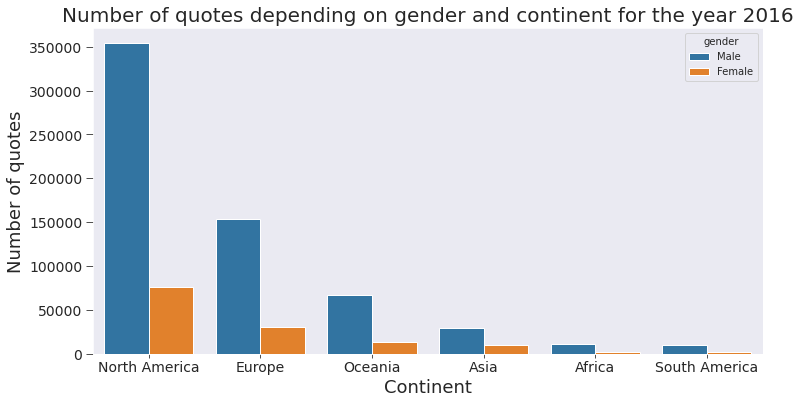

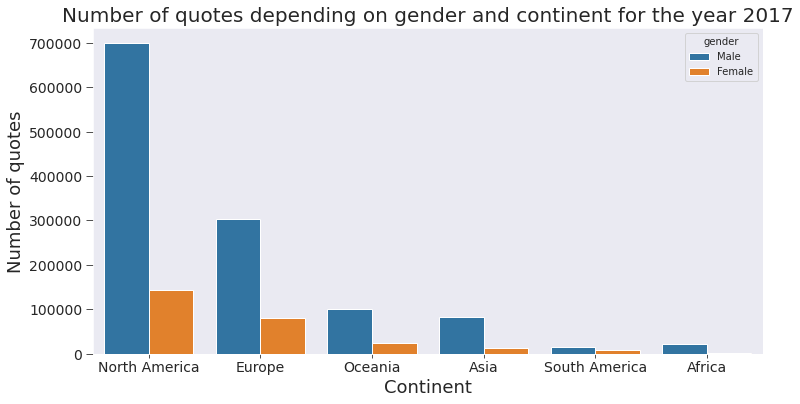

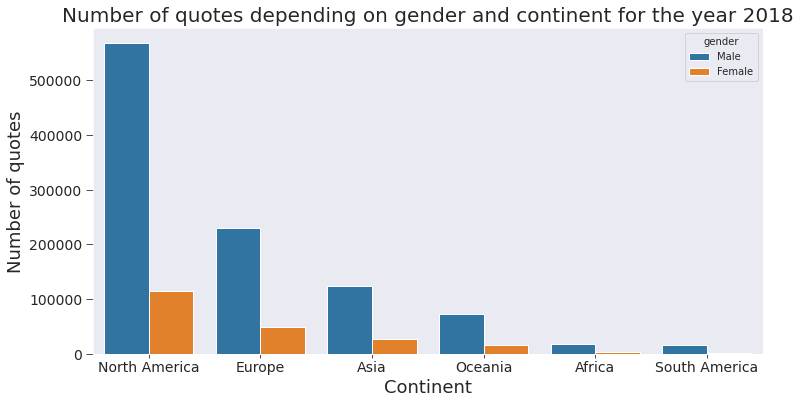

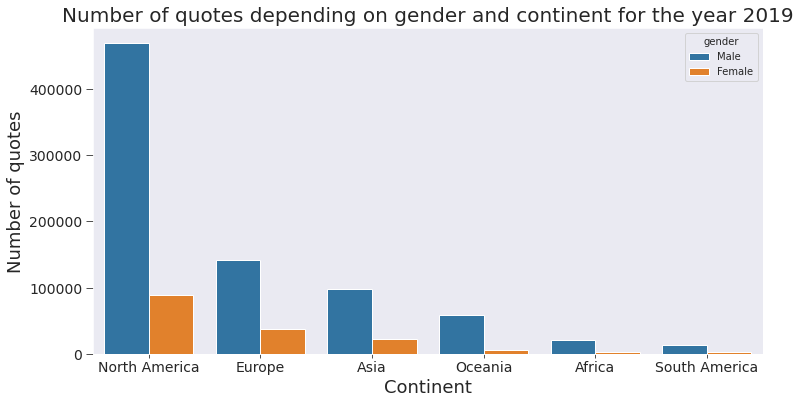

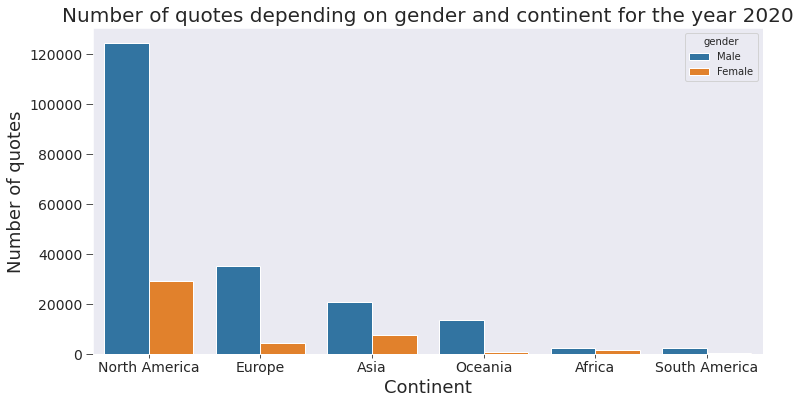

In [22]:
for df in df_list:
    plot_quotes_continent(df)

**Observation**:

- These plots summarise the previous analysis done per country.
- Again, there is a clear gap between the genders for every continent. There is no year nor continent where females were quoted more.
- As mentioned previously, North America is the source of the majority of quotes, followed by Europe. This information is important to keep in mind in the next analysis (for example, when looking at topics/categories of quotes) when all countries are mixed as it adds cultural context and could explain other underlying trends.
- In a future step, the proportion of males/females per continent will be also analysed, in order to allow relative comparison between continents.




## Number of quotes per media

In [23]:
#to be improved in the future to keep all the sitenames and not the first one only

#To be run once only !
for df in df_list:
    df["sitenames"] = extract_element_from_series(df['sitenames'])

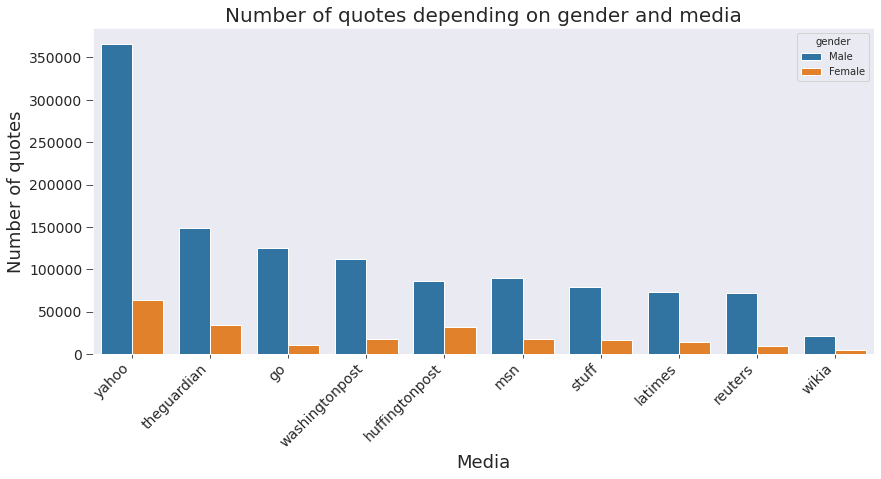

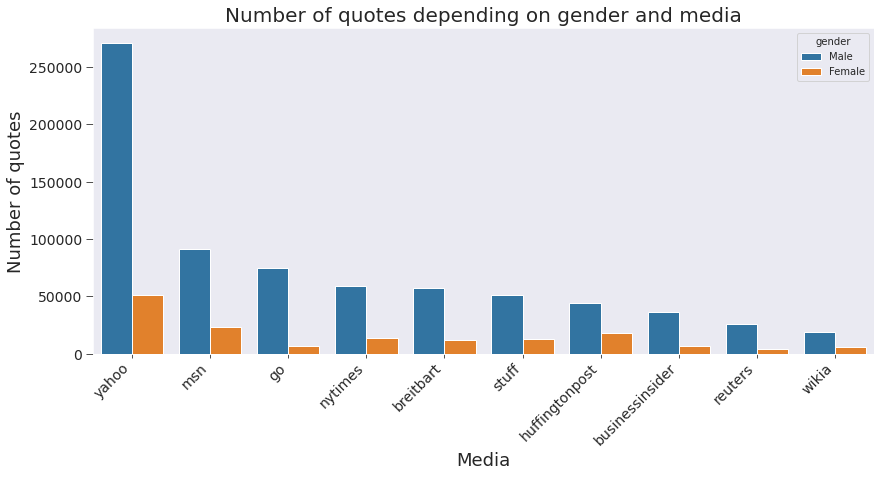

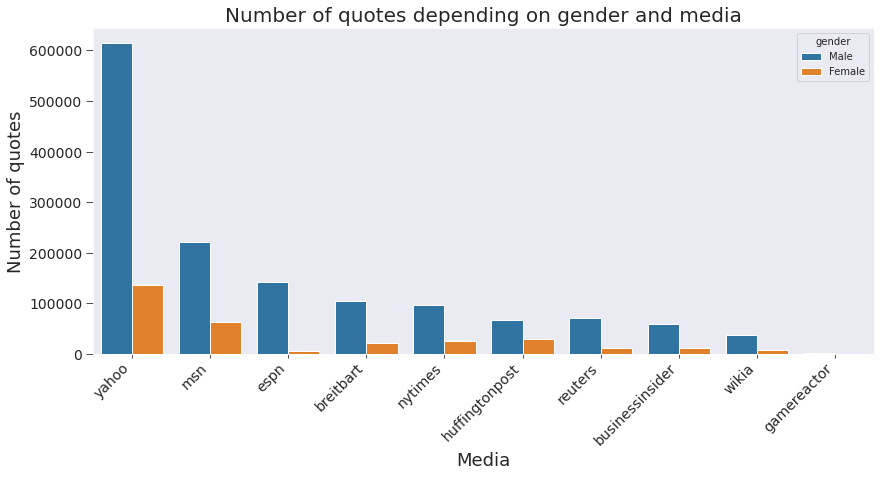

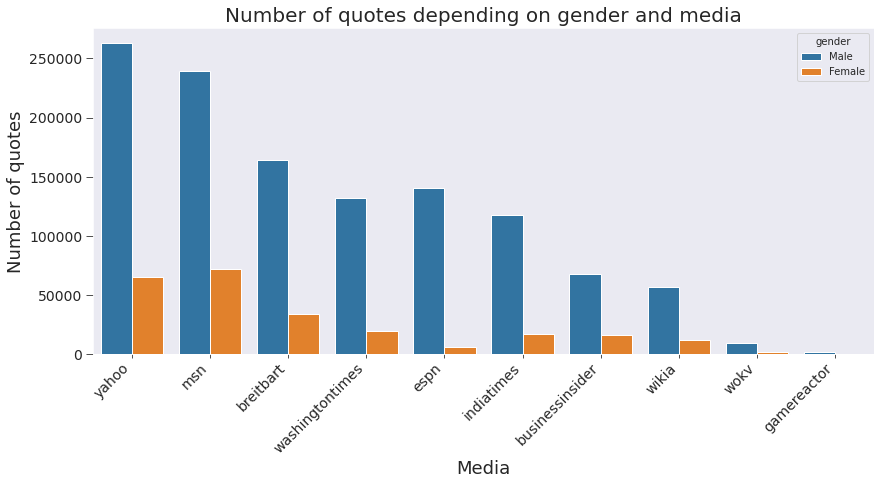

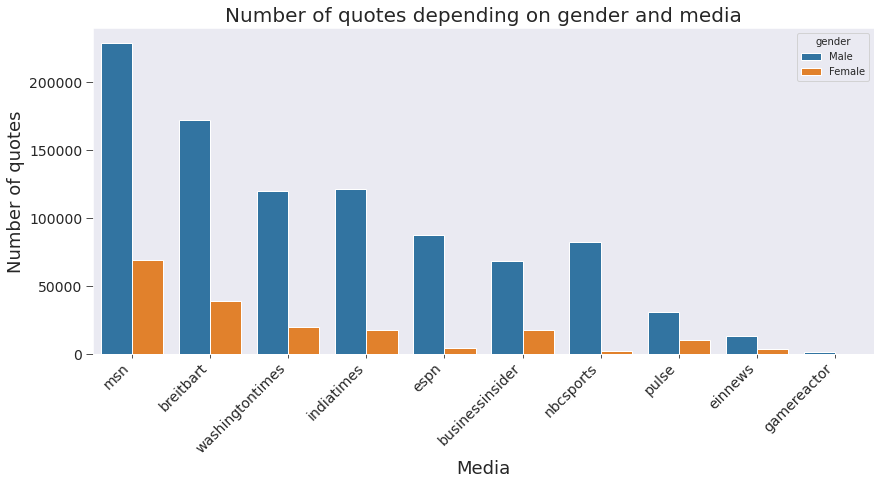

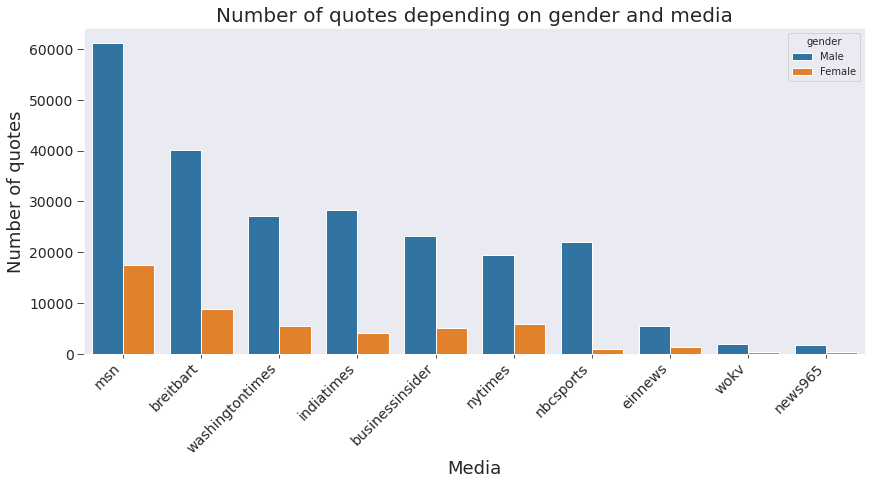

In [24]:
for df in df_list:
    plot_quotes_media(df)

**Observation**:

- These bar charts show the distribution of quotes between the media sources, depending on gender.
- Over the years, the set of sources stays more or less the same, with a couple sources changing between years.
- All of the media sources quote males more than females.
- In future steps, the relative proportions will be analysed.
- At a first glance, there seems to be little change in proportions over the years, although firther plots and tests are needed to confirm this.




## Number of quotes per category 

In [71]:
for df in df_list:
    df['tags'] = transform_tags(df)

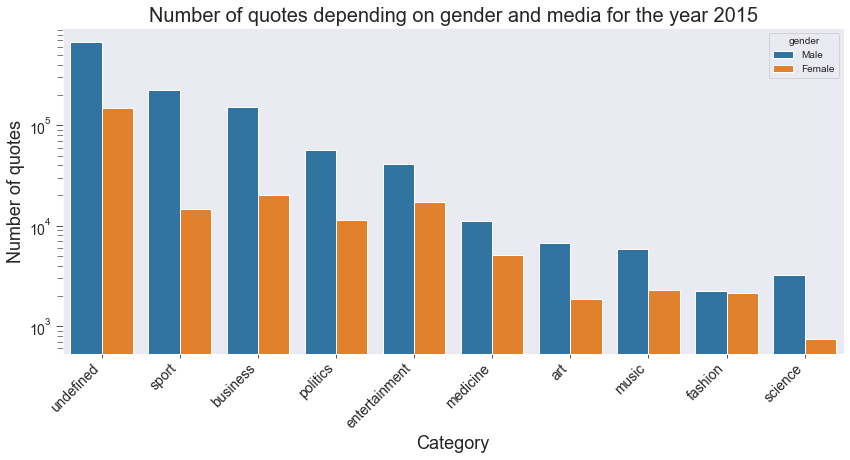

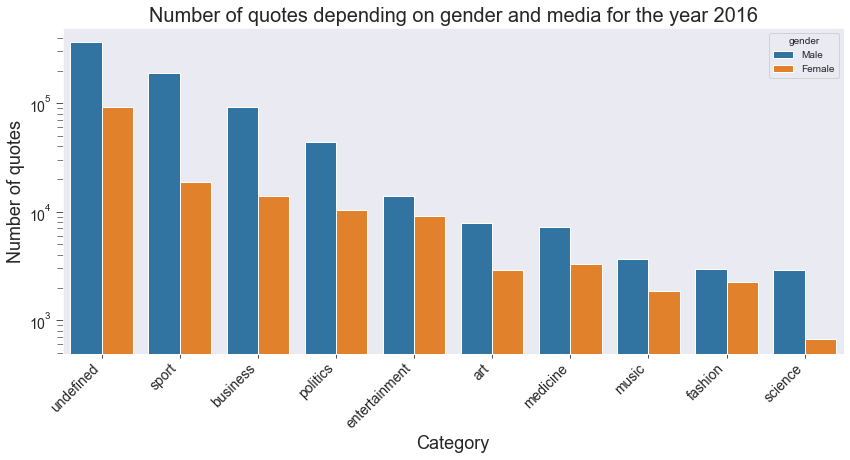

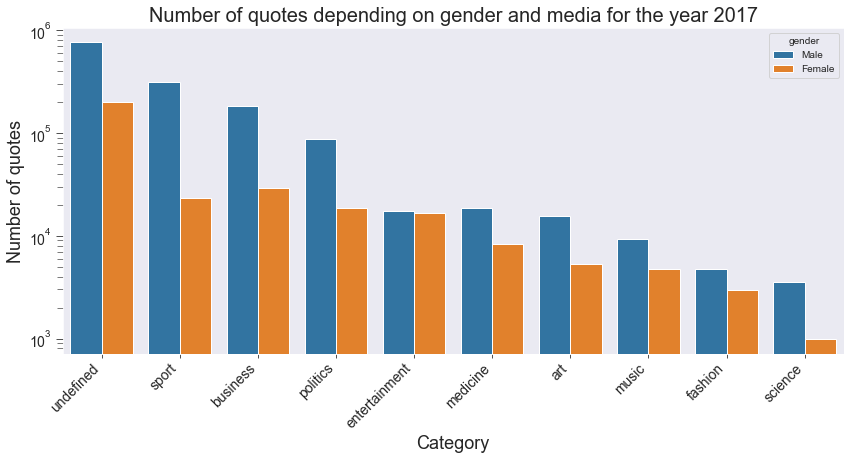

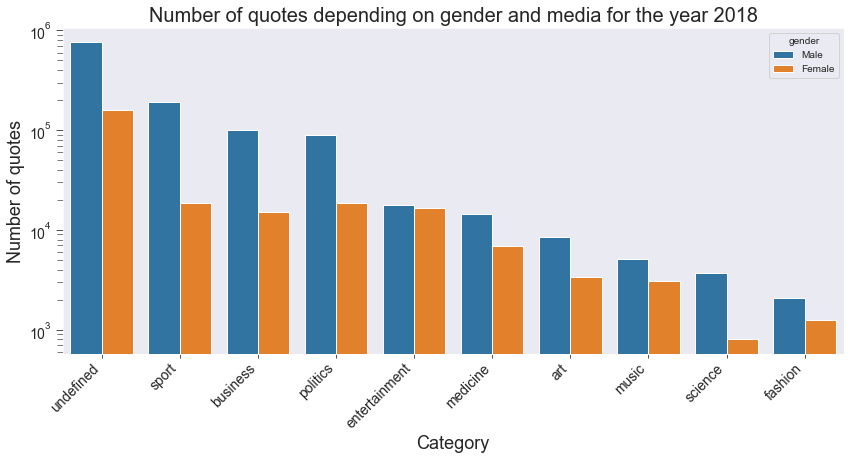

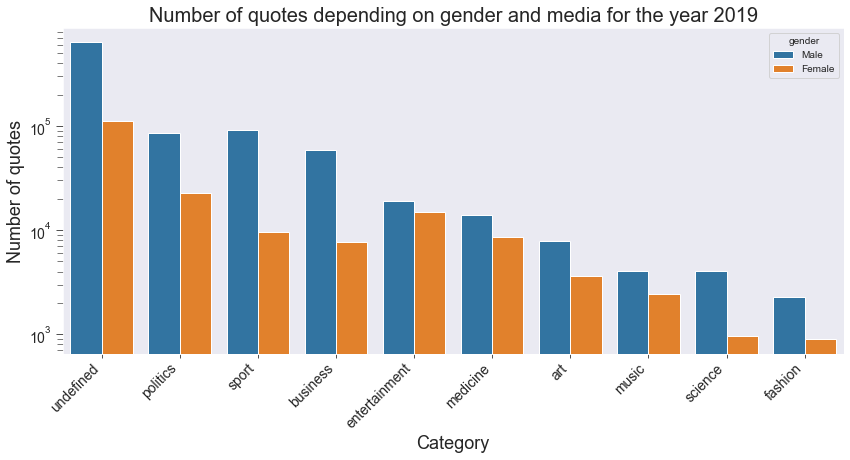

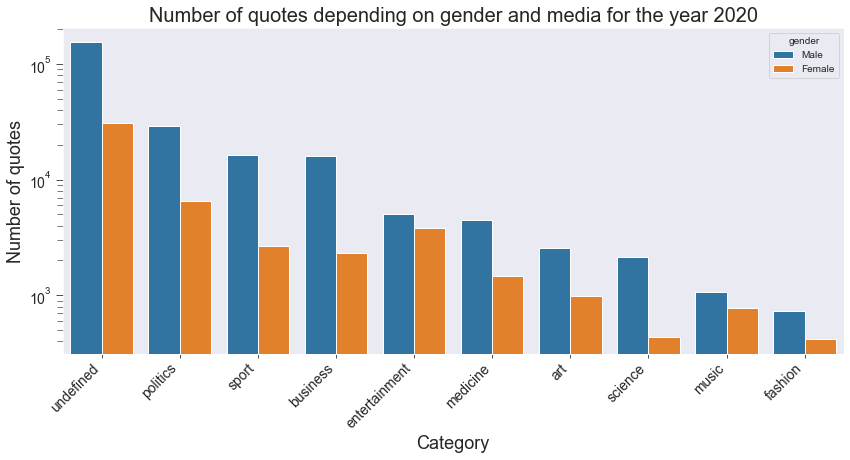

In [74]:
for df in df_list:
    plot_quotes_categories(df)

**Observations**:

- The predefined list that was used to extract categories from URLs was limited. The list will be optimised in order better classify the quotes into various topics. More topics can be added as well as keywords to identify them.
- Sports, politics and business are the most present topics every year. These 3 fields are known to present gender biases, and the plots confirm that males are more represented.
- Certain topics, such as entertainment, appear to have a smaller gap between the number of males and females.
- Nonetheless, the proportion of females never exceeds the one of males.
- Topics typically attributed to females such as fashion still remain more quoted by males.
- Again, we will be analysing the relative propotion in future steps.



## Country of specific media

In [ ]:
for df in df_list : 
    df = compute_country_from_qid(df)

In [ ]:
for df in df_list : 
    plot_quotes_media_country(df)

## Length of quotes

In [98]:
for df in df_list:
    df = compute_quotation_length(df)

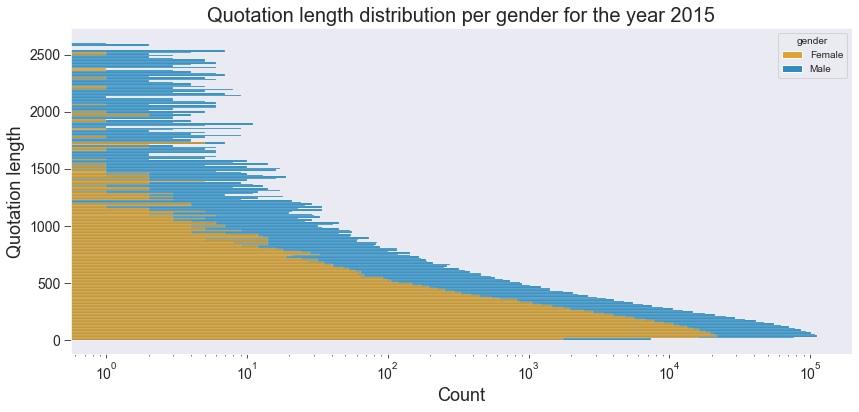

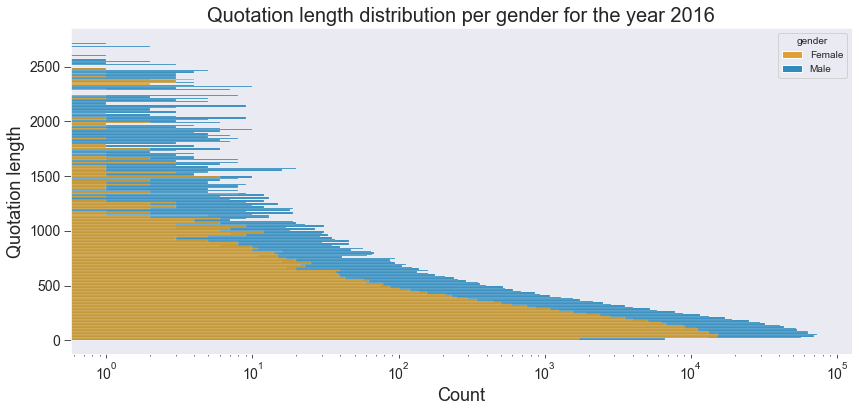

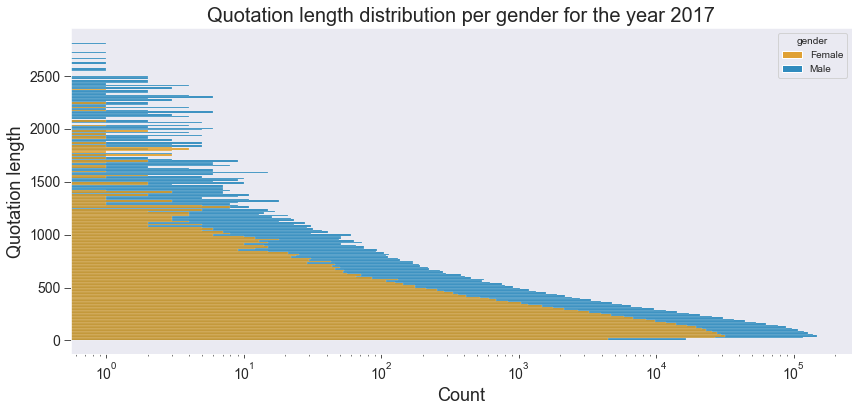

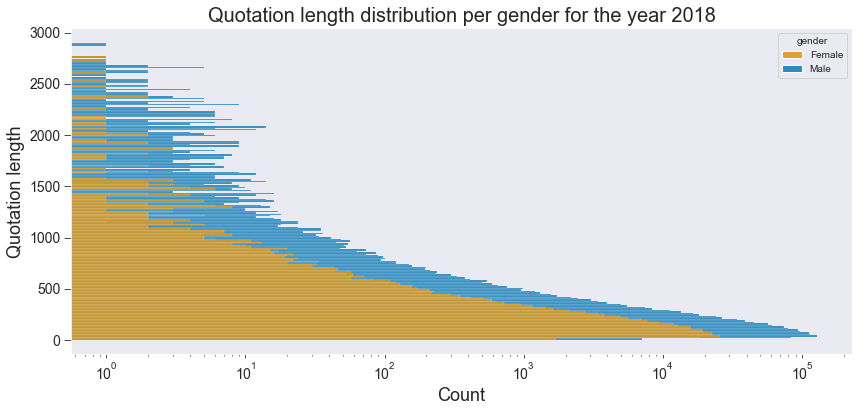

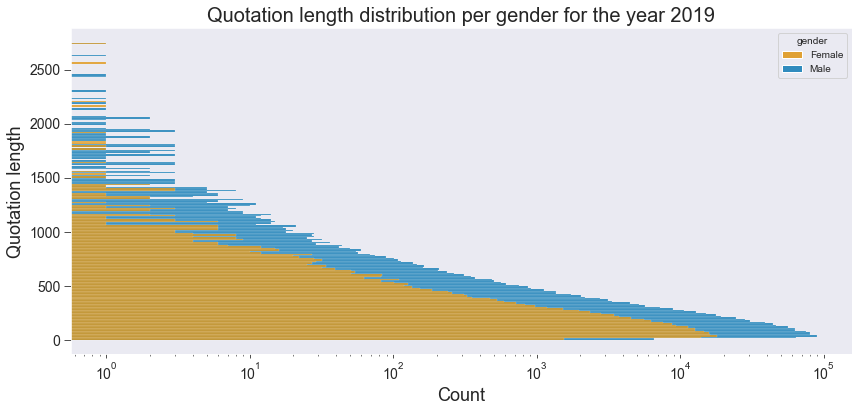

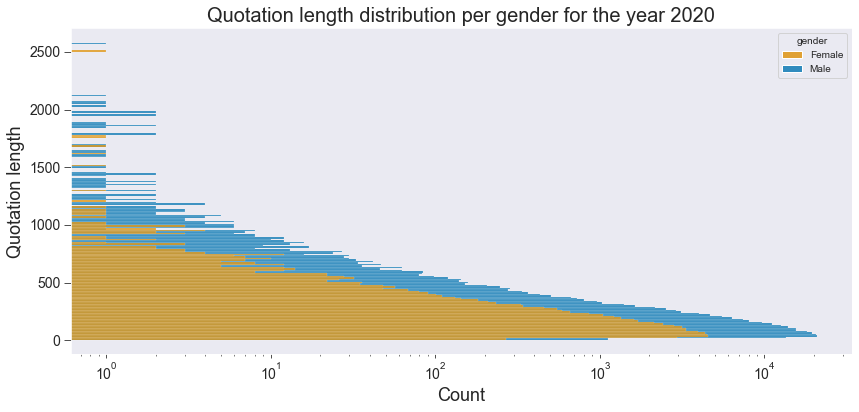

In [135]:
for df in df_list:
    plot_quotes_distribution(df)

In [26]:
plot_avg_quotes_length(df_2020, conf_int=95)

KeyError: 'quotation_length'

<Figure size 576x720 with 0 Axes>

In [25]:
for df in df_list:
    plot_avg_quotes_length(df, conf_int=95)

KeyError: 'quotation_length'

<Figure size 576x720 with 0 Axes>

In [142]:
print('Null hypothesis : the length of the quotes in the most popular media is independant of the gender')
for df in df_list:
    year = df['quoteID'][0][0:4]
    
    print('\nFor the year '+ year, ':')
    pvalue = T_test(df['quotation_length'][df['gender'] == 'Female'], 
                    df['quotation_length'][df['gender'] == 'Male'])
    if pvalue < 0.05:
        print('The p-value of this statistical test amounts to', np.round(pvalue,4), "we therefore have to reject the null hypothesis.")
    else:
        print('The p-value of this statistical test amounts to', np.round(pvalue,4), "we therefore cannot reject the null hypothesis.")

Null hypothesis : the length of the quotes in the most popular media is independant of the gender

For the year 2015 :
The p-value of this statistical test amounts to 0.0 we therefore have to reject the null hypothesis.

For the year 2016 :
The p-value of this statistical test amounts to 0.0 we therefore have to reject the null hypothesis.

For the year 2017 :
The p-value of this statistical test amounts to 0.0017 we therefore have to reject the null hypothesis.

For the year 2018 :
The p-value of this statistical test amounts to 0.0 we therefore have to reject the null hypothesis.

For the year 2019 :
The p-value of this statistical test amounts to 0.0 we therefore have to reject the null hypothesis.

For the year 2020 :
The p-value of this statistical test amounts to 0.3833 we therefore cannot reject the null hypothesis.


**Interpretation** : 
-

## Quotes per journals

#### **Basic data analysis**

NOTE FOR US Check on the read me for plots and stuff to do:

*Note*: For this hand in we will not look into questions that are computed over the years since we only focus on a subset of the whole data 

Comparison of number of male versus female quotes
USE FUNCTIONS TO PLOT TO RUN IT FOR EACH YEAR
Lisa : 
- Overall difference in count of males versus females, over all years.
- Overall count of male versus female quotes, per year.
- Overall count of male versus female quotes, per category.
- Overall count of male versus female quotes, per year and per category.
- Overall count of male versus female quotes, per country/geographical location.
- Overall count of male versus female quotes, per year and per country/geographical location.
Arthur : 
- Compare length of quotes 

Tests for statistical significance
Arthur : 
- Perform statistical tests to see if the difference between counts of males and females per year is statistically significant.
- Perform statistical tests to see if the difference per year and per category is statistically significant.
- Perform statistical tests to see if the difference per year and per location is statistically significant.
